In [63]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
file_tot_name = 'CasosGeneroEtario.csv'
fold_tot_path = r'..\Datos-COVID19\output\producto16'
file_tot_path = os.path.join(fold_tot_path, file_tot_name)

file_uci_name = 'HospitalizadosUCIEtario_T.csv'
fold_uci_path = r'..\Datos-COVID19\output\producto9'
file_uci_path = os.path.join(fold_uci_path, file_uci_name)

In [74]:
df_all = pd.read_csv(file_tot_path)
df_uci = pd.read_csv(file_uci_path)
#display(df_all, df_uci)

In [75]:
def trans_dfall(df_tot):
    lst_df = []
    for grp, df in df_tot.groupby('Sexo'):
        columns = df['Grupo de edad']
        df_t = df.transpose()
        df_t.columns = columns
        df_t = df_t.drop(['Grupo de edad', 'Sexo'])
        lst_df.append(df_t)

    df_tot = lst_df[0] + lst_df[1]
    col = df_tot.index.values.astype(str)
    df_tot.reset_index(drop=True, inplace=True)
    df_tot['Grupo de edad'] = col

    df_tot['<=39']  = df_tot.loc[:,'00 - 04 años':'35 - 39 años'].sum(axis=1)
    df_tot.drop(columns=['00 - 04 años', '05 - 09 años', '10 - 14 años', '15 - 19 años', '20 - 24 años', '25 - 29 años', '30 - 34 años', '35 - 39 años'], inplace=True)
    df_tot['40-49'] = df_tot.loc[:,'40 - 44 años':'45 - 49 años'].sum(axis=1)
    df_tot.drop(columns=['40 - 44 años', '45 - 49 años'], inplace=True)
    df_tot['50-59'] = df_tot.loc[:,'50 - 54 años':'55 - 59 años'].sum(axis=1)
    df_tot.drop(columns=['50 - 54 años', '55 - 59 años'], inplace=True)
    df_tot['60-69'] = df_tot.loc[:,'60 - 64 años':'65 - 69 años'].sum(axis=1)
    df_tot.drop(columns=['60 - 64 años', '65 - 69 años'], inplace=True)
    df_tot['>=70']  = df_tot.loc[:,'70 - 74 años':'80 y más años'].sum(axis=1)
    df_tot.drop(columns=['70 - 74 años', '75 - 79 años', '80 y más años'], inplace=True)
    
    return df_tot


def inter_df(df):
    index = list(df['Grupo de edad'].values)
    index = [pd.to_datetime(ind) for ind in index]
    df.index = index
    df = df.resample('D').mean()
    df = df.interpolate()
    col = df.index.strftime("%Y-%m-%d")
    df.reset_index(drop=True, inplace=True)
    df['Grupo de edad'] = col
    
    return df
    
    
def trans_dfuci(df_uci, date_s, date_e):
    date_p = pd.to_datetime(date_s) - pd.Timedelta(days=1)
    date_p = date_p.strftime("%Y-%m-%d")

    mask_s = df_uci['Grupo de edad'] >= date_s
    mask_e = df_uci['Grupo de edad'] <= date_e
    mask = mask_s & mask_e

    df_uci = df_uci[mask]
    ts_uci = pd.DataFrame([[date_p,0,0,0,0,0]], columns=['Grupo de edad','<=39','40-49','50-59','60-69','>=70'])
    df_uci = pd.concat([ts_uci, df_uci])
    df_uci = df_uci.reset_index(drop=True)

    df_uci['nu, <=39']  = df_uci['<=39'].diff(periods=1)
    df_uci['nu, 40-49'] = df_uci['40-49'].diff(periods=1)
    df_uci['nu, 50-59'] = df_uci['50-59'].diff(periods=1)
    df_uci['nu, 60-69'] = df_uci['60-69'].diff(periods=1)
    df_uci['nu, >=70']  = df_uci['>=70'].diff(periods=1)
    df_uci = df_uci.reset_index(drop=True)
    df_uci.drop([0] , axis=0, inplace=True)

    for ind in df_uci.index:
        if df_uci['nu, <=39'][ind] < 0:
            df_uci['nu, <=39'][ind] = 0
        if df_uci['nu, 40-49'][ind] < 0:
            df_uci['nu, 40-49'][ind] = 0
        if df_uci['nu, 50-59'][ind] < 0:
            df_uci['nu, 50-59'][ind] = 0
        if df_uci['nu, 60-69'][ind] < 0:
            df_uci['nu, 60-69'][ind] = 0
        if df_uci['nu, >=70'][ind] < 0:
            df_uci['nu, >=70'][ind] = 0

    df_uci['cum, <=39']  = df_uci['nu, <=39'].cumsum()
    df_uci['cum, 40-49'] = df_uci['nu, 40-49'].cumsum()
    df_uci['cum, 50-59'] = df_uci['nu, 50-59'].cumsum()
    df_uci['cum, 60-69'] = df_uci['nu, 60-69'].cumsum()
    df_uci['cum, >=70']  = df_uci['nu, >=70'].cumsum()

    return df_uci

def add_ratio(df_all, df_uci):
    lst_uci_39 = [] ; lst_uci_49 = [] 
    lst_uci_59 = [] ; lst_uci_69 = []
    lst_uci_70 = [] 
    for ind in df_uci.index:
        date = df_uci['Grupo de edad'][ind]
        tot = df_all[df_all['Grupo de edad']==date]['<=39'].values
        uci = df_uci['cum, <=39'][ind]
        lst_uci_39.append(round(float(uci/tot),3))
        tot = df_all[df_all['Grupo de edad']==date]['40-49'].values
        uci = df_uci['cum, 40-49'][ind]
        lst_uci_49.append(round(float(uci/tot),3))
        tot = df_all[df_all['Grupo de edad']==date]['50-59'].values
        uci = df_uci['cum, 50-59'][ind]
        lst_uci_59.append(round(float(uci/tot),3))
        tot = df_all[df_all['Grupo de edad']==date]['60-69'].values
        uci = df_uci['cum, 60-69'][ind]
        lst_uci_69.append(round(float(uci/tot),3))
        tot = df_all[df_all['Grupo de edad']==date]['>=70'].values
        uci = df_uci['cum, >=70'][ind]
        lst_uci_70.append(round(float(uci/tot),3))
    df_all['cum %, <=39']  = lst_uci_39
    df_all['cum %, 40-49'] = lst_uci_49
    df_all['cum %, 50-59'] = lst_uci_59
    df_all['cum %, 60-69'] = lst_uci_69
    df_all['cum %, >=70']  = lst_uci_70
    df_all.drop([0] , axis=0, inplace=True)
    
    return df_all

In [76]:
df_all = trans_dfall(df_all)
df_all = inter_df(df_all)
date_s = df_all['Grupo de edad'].iloc[0]
date_e = df_all['Grupo de edad'].iloc[-1]
df_uci = trans_dfuci(df_uci, date_s, date_e)
df_all = add_ratio(df_all, df_uci)
#display(df_all, df_uci)

C:\Users\HN566KT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\HN566KT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\HN566KT\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\HN566KT\AppData\

In [77]:
x_tim = df_all['Grupo de edad'].values

y_39 = df_all['<=39'].values
y_49 = df_all['40-49'].values
y_59 = df_all['50-59'].values
y_69 = df_all['60-69'].values
y_70 = df_all['>=70'].values

yp_39 = df_all['cum %, <=39'].values
yp_49 = df_all['cum %, 40-49'].values
yp_59 = df_all['cum %, 50-59'].values
yp_69 = df_all['cum %, 60-69'].values
yp_70 = df_all['cum %, >=70'].values

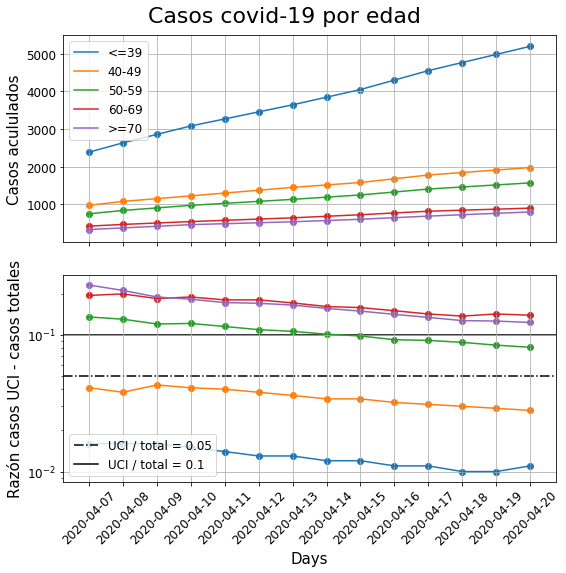

In [78]:
fig, axs = plt.subplots(2, sharex=True, figsize=(8,8))
fig.suptitle('Casos covid-19 por edad',  y=0.99, fontsize = 22)

axs[0].plot(x_tim, y_39, label='<=39')
axs[0].scatter(x_tim, y_39)
axs[0].plot(x_tim, y_49, label='40-49')
axs[0].scatter(x_tim, y_49)
axs[0].plot(x_tim, y_59, label='50-59')
axs[0].scatter(x_tim, y_59)
axs[0].plot(x_tim, y_69, label='60-69')
axs[0].scatter(x_tim, y_69)
axs[0].plot(x_tim, y_70, label='>=70')
axs[0].scatter(x_tim, y_70)
axs[0].set_ylabel('Casos acululados', fontsize = 15)
axs[0].legend(loc='upper left', fontsize = 12)
axs[0].tick_params('y', labelsize=12)
axs[0].grid()

axs[1].plot(x_tim, yp_39)
axs[1].scatter(x_tim, yp_39)
axs[1].plot(x_tim, yp_49)
axs[1].scatter(x_tim, yp_49)
axs[1].plot(x_tim, yp_59)
axs[1].scatter(x_tim, yp_59)
axs[1].plot(x_tim, yp_69)
axs[1].scatter(x_tim, yp_69)
axs[1].plot(x_tim, yp_70)
axs[1].scatter(x_tim, yp_70)
axs[1].set_ylabel('Razón casos UCI - casos totales', fontsize = 15)
axs[1].set_xlabel('Days', fontsize = 15)
axs[1].axhline(y=0.05, c="k", linestyle='-.', zorder=0, label='UCI / total = 0.05')
axs[1].axhline(y=0.1, c="k", linestyle='-', zorder=0, label='UCI / total = 0.1')
axs[1].legend(loc='lower left', fontsize = 12)
axs[1].set_yscale('log')
axs[1].grid()
axs[1].tick_params('x', labelrotation=45, labelsize=12)
axs[1].tick_params('y', labelsize=12)

fig.tight_layout()
plt.subplots_adjust(top=0.94)


In [71]:
48/4770

0.010062893081761006